In [27]:
import numpy as np
import pandas as pd
import os
import gc
import random
import copy
random.seed(1024)

In [2]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from IPython.display import display

# Gradient Boosting
import lightgbm as lgb

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')

In [3]:
id_col = "ID"
target_var = "target"

print("Loading Data...")
df_train = pd.read_csv("./train.csv", index_col=id_col)
training_index = df_train.index
df_test = pd.read_csv("./test.csv", index_col=id_col)
test_index = df_test.index

y = np.log1p(df_train[target_var])
df_train.drop(target_var, axis=1, inplace=True)

print('Train shape: {} Rows, {} Columns'.format(*df_train.shape))
print('Test shape: {} Rows, {} Columns'.format(*df_test.shape))

print("Combine Train and Test")
df = pd.concat([df_train, df_test], axis=0)
del df_train, df_test
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))

Loading Data...
Train shape: 4459 Rows, 4991 Columns
Test shape: 49342 Rows, 4991 Columns
Combine Train and Test

All Data shape: 53801 Rows, 4991 Columns


In [4]:
# Modeling Datasets
test_df = df.loc[test_index,:]
vocab = df.columns

# LGBM Dataset
lgtrain = lgb.Dataset(df.loc[training_index,vocab],y ,feature_name = "auto")
print("Starting LightGBM. Train shape: {}, Test shape: {}".format(df.loc[training_index,:].shape,test_df.shape))
print("Feature Num: ",len(vocab))
del df; gc.collect();

Starting LightGBM. Train shape: (4459, 4991), Test shape: (49342, 4991)
Feature Num:  4991


In [ ]:
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    "learning_rate": 0.01,
    "num_leaves": 180,
    "feature_fraction": 0.50,
    "bagging_fraction": 0.50,
    'bagging_freq': 4,
    "max_depth": -1,
    "reg_alpha": 0.3,
    "reg_lambda": 0.1,
    #"min_split_gain":0.2,
    "min_child_weight":10,
    'zero_as_missing':True,
    'device': 'gpu',
                }

In [ ]:
results = pd.DataFrame(columns = ["Rounds","Score","STDV", "LB", "Parameters"])
# Find Optimal Parameters / Boosting Rounds
lgb_cv = lgb.cv(
    params = lgbm_params,
    train_set = lgtrain,
    num_boost_round=2000,
    stratified=False,
    nfold = 5,
    verbose_eval=50,
    seed = 23,
    early_stopping_rounds=75)

optimal_rounds = np.argmin(lgb_cv['rmse-mean'])
best_cv_score = min(lgb_cv['rmse-mean'])

print("\nOptimal Round: {}\nOptimal Score: {} + {}".format(
    optimal_rounds,best_cv_score,lgb_cv['rmse-stdv'][optimal_rounds]))

results = results.append({"Rounds": optimal_rounds,
                          "Score": best_cv_score,
                          "STDV": lgb_cv['rmse-stdv'][optimal_rounds],
                          "LB": None,
                          "Parameters": lgbm_params}, ignore_index=True)

In [ ]:
pd.set_option('max_colwidth', 800)
display(results.sort_values(by="Score",ascending = True))

In [5]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

results = pd.DataFrame(columns = ["Rounds","Score","STDV", "Parameters"])

def objective(params):
    lgbm_params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        "learning_rate": 0.01,
        "bagging_fraction": 0.8,
        'bagging_freq': 4,
        "reg_alpha": 0.3,
        "reg_lambda": 0.1,
        "min_child_weight": 10,
        'zero_as_missing': True,
        'feature_fraction_seed': 5,
        'device': 'gpu',
    }
    
    params['num_leaves'] = int(params['num_leaves'])
    params['feature_fraction'] = '{:.3f}'.format(params['feature_fraction'])
    cv_params = dict(lgbm_params, **params)
    
    lgb_cv = lgb.cv(
        params = cv_params,
        train_set = lgtrain,
        num_boost_round=2000,
        stratified=False,
        nfold = 3,
        verbose_eval=10000,
        seed = 1234,
        early_stopping_rounds=75)
    
    score = np.min(lgb_cv['rmse-mean'])
    optimal_rounds = np.argmin(lgb_cv['rmse-mean'])
    print("Params: {}".format(params))
    print("Optimal Round: {}\nOptimal Score: {} + {}".format(
        optimal_rounds,score,lgb_cv['rmse-stdv'][optimal_rounds]))
    global results
    results = results.append({"Rounds": optimal_rounds,
                          "Score": score,
                          "STDV": lgb_cv['rmse-stdv'][optimal_rounds],
                          "Parameters": params}, ignore_index=True)
    print("###########################################################################################")

    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 40, 320, 2),
    'feature_fraction': hp.uniform('feature_fraction', 0.4, 1.0),
    'max_depth': hp.choice('max_depth', [-1,4,6,8,12,16,24,32]),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=500)

Params: {'feature_fraction': '0.994', 'max_depth': 6, 'num_leaves': 36}
Optimal Round: 701
Optimal Score: 1.4475485462521605 + 0.008393263017899597
###########################################################################################
Params: {'feature_fraction': '0.663', 'max_depth': 16, 'num_leaves': 60}
Optimal Round: 393
Optimal Score: 1.4354457219911687 + 0.005831930719646793
###########################################################################################
Params: {'feature_fraction': '0.851', 'max_depth': 24, 'num_leaves': 12}
Optimal Round: 710
Optimal Score: 1.449511279197058 + 0.009030143247951589
###########################################################################################
Params: {'feature_fraction': '0.815', 'max_depth': 6, 'num_leaves': 140}
Optimal Round: 778
Optimal Score: 1.4465160447131524 + 0.0076460385052734454
###########################################################################################
Params: {'feature_fraction': '0.531',

Params: {'feature_fraction': '0.869', 'max_depth': 24, 'num_leaves': 180}
Optimal Round: 318
Optimal Score: 1.4364139527355277 + 0.005559618850011146
###########################################################################################
Params: {'feature_fraction': '0.822', 'max_depth': 32, 'num_leaves': 100}
Optimal Round: 305
Optimal Score: 1.4366303111069614 + 0.0053632929373399986
###########################################################################################
Params: {'feature_fraction': '0.509', 'max_depth': 6, 'num_leaves': 60}
Optimal Round: 718
Optimal Score: 1.4431368982205954 + 0.008886891248011178
###########################################################################################
Params: {'feature_fraction': '0.906', 'max_depth': 4, 'num_leaves': 12}
Optimal Round: 1042
Optimal Score: 1.4527987677949363 + 0.010289139092095235
###########################################################################################
Params: {'feature_fraction': '0.54

Params: {'feature_fraction': '0.451', 'max_depth': -1, 'num_leaves': 140}
Optimal Round: 319
Optimal Score: 1.4286126298264215 + 0.007294660849225483
###########################################################################################
Params: {'feature_fraction': '0.546', 'max_depth': -1, 'num_leaves': 140}
Optimal Round: 324
Optimal Score: 1.4302690636455362 + 0.00545483046431256
###########################################################################################
Params: {'feature_fraction': '0.401', 'max_depth': 32, 'num_leaves': 140}
Optimal Round: 333
Optimal Score: 1.428487228454449 + 0.007745956303319776
###########################################################################################
Params: {'feature_fraction': '0.513', 'max_depth': -1, 'num_leaves': 100}
Optimal Round: 325
Optimal Score: 1.4304108639308206 + 0.005803979128398305
###########################################################################################
Params: {'feature_fraction': '0.41

Params: {'feature_fraction': '0.505', 'max_depth': 6, 'num_leaves': 100}
Optimal Round: 753
Optimal Score: 1.4432216831041265 + 0.00804884787578464
###########################################################################################
Params: {'feature_fraction': '0.998', 'max_depth': -1, 'num_leaves': 12}
Optimal Round: 707
Optimal Score: 1.4514995568450033 + 0.011404870046186035
###########################################################################################
Params: {'feature_fraction': '0.402', 'max_depth': 32, 'num_leaves': 180}
Optimal Round: 342
Optimal Score: 1.429584611635646 + 0.006793376740607093
###########################################################################################
Params: {'feature_fraction': '0.794', 'max_depth': 12, 'num_leaves': 60}
Optimal Round: 401
Optimal Score: 1.4386687772631082 + 0.007225895501961526
###########################################################################################
Params: {'feature_fraction': '0.420',

Params: {'feature_fraction': '0.760', 'max_depth': 32, 'num_leaves': 100}
Optimal Round: 312
Optimal Score: 1.4352457708419981 + 0.0068120282644707686
###########################################################################################
Params: {'feature_fraction': '0.412', 'max_depth': -1, 'num_leaves': 180}
Optimal Round: 340
Optimal Score: 1.4301082944277275 + 0.006998940053373701
###########################################################################################
Params: {'feature_fraction': '0.441', 'max_depth': 16, 'num_leaves': 140}
Optimal Round: 431
Optimal Score: 1.431973638811029 + 0.007237019279500845
###########################################################################################
Params: {'feature_fraction': '0.504', 'max_depth': 32, 'num_leaves': 12}
Optimal Round: 826
Optimal Score: 1.4468352366546204 + 0.010776525148979485
###########################################################################################
Params: {'feature_fraction': '0.7

Params: {'feature_fraction': '0.447', 'max_depth': 8, 'num_leaves': 180}
Optimal Round: 607
Optimal Score: 1.4393220545555885 + 0.00937764000875221
###########################################################################################
Params: {'feature_fraction': '0.515', 'max_depth': 24, 'num_leaves': 140}
Optimal Round: 328
Optimal Score: 1.4312386250225568 + 0.006930922205084642
###########################################################################################
Params: {'feature_fraction': '0.430', 'max_depth': 32, 'num_leaves': 36}
Optimal Round: 394
Optimal Score: 1.4315205584065351 + 0.008910554425553482
###########################################################################################
Params: {'feature_fraction': '0.401', 'max_depth': 4, 'num_leaves': 140}
Optimal Round: 1064
Optimal Score: 1.4495345676276694 + 0.011309565236982089
###########################################################################################
Params: {'feature_fraction': '0.473

Params: {'feature_fraction': '0.476', 'max_depth': 32, 'num_leaves': 60}
Optimal Round: 345
Optimal Score: 1.4284601494030362 + 0.005797119401926075
###########################################################################################
Params: {'feature_fraction': '0.547', 'max_depth': 24, 'num_leaves': 180}
Optimal Round: 324
Optimal Score: 1.431467670902166 + 0.004805369543975095
###########################################################################################
Params: {'feature_fraction': '0.803', 'max_depth': 4, 'num_leaves': 140}
Optimal Round: 973
Optimal Score: 1.45129668682405 + 0.009432537146130134
###########################################################################################
Params: {'feature_fraction': '0.444', 'max_depth': 6, 'num_leaves': 140}
Optimal Round: 809
Optimal Score: 1.4421962437636913 + 0.008333091440092852
###########################################################################################
Params: {'feature_fraction': '0.708', 

Params: {'feature_fraction': '0.632', 'max_depth': 24, 'num_leaves': 60}
Optimal Round: 326
Optimal Score: 1.4326366202826684 + 0.005040656652479828
###########################################################################################
Params: {'feature_fraction': '0.526', 'max_depth': 32, 'num_leaves': 60}
Optimal Round: 321
Optimal Score: 1.4300762094590127 + 0.005269046600457918
###########################################################################################
Params: {'feature_fraction': '0.413', 'max_depth': -1, 'num_leaves': 60}
Optimal Round: 343
Optimal Score: 1.4289422659089002 + 0.006904678390057213
###########################################################################################
Params: {'feature_fraction': '0.472', 'max_depth': 32, 'num_leaves': 60}
Optimal Round: 325
Optimal Score: 1.4286846587360191 + 0.006261790144259947
###########################################################################################
Params: {'feature_fraction': '0.514'

Params: {'feature_fraction': '0.452', 'max_depth': 32, 'num_leaves': 36}
Optimal Round: 427
Optimal Score: 1.4316270362859036 + 0.007850211878748233
###########################################################################################
Params: {'feature_fraction': '0.513', 'max_depth': 8, 'num_leaves': 60}
Optimal Round: 609
Optimal Score: 1.4402599008457442 + 0.006971255959562258
###########################################################################################
Params: {'feature_fraction': '0.488', 'max_depth': 32, 'num_leaves': 180}
Optimal Round: 318
Optimal Score: 1.4286816258154964 + 0.006142974689365137
###########################################################################################
Params: {'feature_fraction': '0.428', 'max_depth': 32, 'num_leaves': 12}
Optimal Round: 823
Optimal Score: 1.4465968693955542 + 0.009482356607670463
###########################################################################################
Params: {'feature_fraction': '0.558'

Params: {'feature_fraction': '0.431', 'max_depth': 32, 'num_leaves': 60}
Optimal Round: 363
Optimal Score: 1.4293566468708965 + 0.006015294740657968
###########################################################################################
Params: {'feature_fraction': '0.400', 'max_depth': 32, 'num_leaves': 36}
Optimal Round: 393
Optimal Score: 1.4324785676412406 + 0.007507193456267653
###########################################################################################
Params: {'feature_fraction': '0.602', 'max_depth': 12, 'num_leaves': 180}
Optimal Round: 415
Optimal Score: 1.4369199925826408 + 0.007495506842118543
###########################################################################################
Params: {'feature_fraction': '0.629', 'max_depth': 16, 'num_leaves': 60}
Optimal Round: 415
Optimal Score: 1.4347912773062594 + 0.007177540585739821
###########################################################################################
Params: {'feature_fraction': '0.852

Params: {'feature_fraction': '0.472', 'max_depth': 32, 'num_leaves': 100}
Optimal Round: 325
Optimal Score: 1.4282342325863981 + 0.00783716730038631
###########################################################################################
Params: {'feature_fraction': '0.499', 'max_depth': -1, 'num_leaves': 36}
Optimal Round: 373
Optimal Score: 1.4321004273448399 + 0.008196421051728887
###########################################################################################
Params: {'feature_fraction': '0.411', 'max_depth': 32, 'num_leaves': 180}
Optimal Round: 324
Optimal Score: 1.430258112076972 + 0.007836970655868667
###########################################################################################
Params: {'feature_fraction': '0.432', 'max_depth': 4, 'num_leaves': 12}
Optimal Round: 1071
Optimal Score: 1.4487626311315431 + 0.010970244326977081
###########################################################################################
Params: {'feature_fraction': '0.677'

Params: {'feature_fraction': '0.759', 'max_depth': 12, 'num_leaves': 60}
Optimal Round: 461
Optimal Score: 1.438490084923308 + 0.005473532283342162
###########################################################################################
Params: {'feature_fraction': '0.927', 'max_depth': 32, 'num_leaves': 140}
Optimal Round: 307
Optimal Score: 1.4370410756508694 + 0.0052270742232897
###########################################################################################
Params: {'feature_fraction': '0.447', 'max_depth': 32, 'num_leaves': 36}
Optimal Round: 383
Optimal Score: 1.4327443594188178 + 0.007616511909141793
###########################################################################################
Params: {'feature_fraction': '0.400', 'max_depth': 8, 'num_leaves': 180}
Optimal Round: 585
Optimal Score: 1.4395896031245694 + 0.010640079231171738
###########################################################################################
Params: {'feature_fraction': '0.435', 

Params: {'feature_fraction': '0.478', 'max_depth': 32, 'num_leaves': 140}
Optimal Round: 318
Optimal Score: 1.4292669451730415 + 0.008030568308328184
###########################################################################################
Params: {'feature_fraction': '0.503', 'max_depth': 32, 'num_leaves': 140}
Optimal Round: 344
Optimal Score: 1.4298224702404692 + 0.004157712611065074
###########################################################################################
Params: {'feature_fraction': '0.428', 'max_depth': 32, 'num_leaves': 140}
Optimal Round: 324
Optimal Score: 1.4293911108543913 + 0.0064177165938582624
###########################################################################################
Params: {'feature_fraction': '0.470', 'max_depth': 32, 'num_leaves': 140}
Optimal Round: 318
Optimal Score: 1.4279729965116665 + 0.007773111449027972
###########################################################################################
Params: {'feature_fraction': '0

Params: {'feature_fraction': '0.539', 'max_depth': 6, 'num_leaves': 60}
Optimal Round: 711
Optimal Score: 1.4443623248954287 + 0.007989215199545673
###########################################################################################
Params: {'feature_fraction': '0.520', 'max_depth': 32, 'num_leaves': 60}
Optimal Round: 324
Optimal Score: 1.429864039359883 + 0.0053624223974422566
###########################################################################################
Params: {'feature_fraction': '0.557', 'max_depth': 16, 'num_leaves': 60}
Optimal Round: 362
Optimal Score: 1.4342032091196648 + 0.00667927152397675
###########################################################################################
Params: {'feature_fraction': '0.400', 'max_depth': 12, 'num_leaves': 60}
Optimal Round: 454
Optimal Score: 1.4371560201203841 + 0.007569147260885891
###########################################################################################
Params: {'feature_fraction': '0.482', 

Params: {'feature_fraction': '0.549', 'max_depth': 32, 'num_leaves': 60}
Optimal Round: 308
Optimal Score: 1.4305291224609915 + 0.005816598163859567
###########################################################################################
Params: {'feature_fraction': '0.461', 'max_depth': 24, 'num_leaves': 180}
Optimal Round: 325
Optimal Score: 1.4294870747285253 + 0.00718358629869883
###########################################################################################
Params: {'feature_fraction': '0.485', 'max_depth': 32, 'num_leaves': 36}
Optimal Round: 387
Optimal Score: 1.4311266145627466 + 0.007729372418002707
###########################################################################################
Params: {'feature_fraction': '0.437', 'max_depth': -1, 'num_leaves': 60}
Optimal Round: 325
Optimal Score: 1.429603347903192 + 0.0062352305303734566
###########################################################################################
Params: {'feature_fraction': '0.963'

In [7]:
best

{'feature_fraction': 0.44949398277065516, 'max_depth': 7, 'num_leaves': 2}

In [17]:
results = pd.DataFrame(columns = ["Rounds","Score","STDV", "Parameters"])

def objective(params):
    lgbm_params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        "learning_rate": 0.01,
        "bagging_fraction": 0.6,
        'bagging_freq': 4,
        "min_child_weight": 10,
        'zero_as_missing': True,
        'feature_fraction_seed': 5,
        'feature_fraction': 0.45,
        'max_depth': 32,
        'num_leaves': 180,
        'device': 'gpu',
    }
    
    params['reg_alpha'] = '{:.3f}'.format(params['reg_alpha'])
    params['reg_lambda'] = '{:.3f}'.format(params['reg_lambda'])
    cv_params = dict(lgbm_params, **params)
    
    lgb_cv = lgb.cv(
        params = cv_params,
        train_set = lgtrain,
        num_boost_round=2000,
        stratified=False,
        nfold = 3,
        verbose_eval=10000,
        seed = 1234,
        early_stopping_rounds=75)
    
    score = np.min(lgb_cv['rmse-mean'])
    optimal_rounds = np.argmin(lgb_cv['rmse-mean'])
    print("Params: {}".format(params))
    print("Optimal Round: {}\nOptimal Score: {} + {}".format(
        optimal_rounds,score,lgb_cv['rmse-stdv'][optimal_rounds]))
    global results
    results = results.append({"Rounds": optimal_rounds,
                          "Score": score,
                          "STDV": lgb_cv['rmse-stdv'][optimal_rounds],
                          "Parameters": params}, ignore_index=True)
    print("###########################################################################################")

    return score

space = {
    'reg_alpha': hp.uniform('reg_alpha', 0.01, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, 1.0),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100)

Params: {'reg_alpha': '0.019', 'reg_lambda': '0.651'}
Optimal Round: 352
Optimal Score: 1.4285379279515553 + 0.008202199671679986
###########################################################################################
Params: {'reg_alpha': '0.155', 'reg_lambda': '0.280'}
Optimal Round: 378
Optimal Score: 1.4281637094236714 + 0.0075004930318959264
###########################################################################################
Params: {'reg_alpha': '0.640', 'reg_lambda': '0.870'}
Optimal Round: 378
Optimal Score: 1.4292180998345525 + 0.006619291947370963
###########################################################################################
Params: {'reg_alpha': '0.144', 'reg_lambda': '0.875'}
Optimal Round: 358
Optimal Score: 1.429706265734182 + 0.0071087188833022655
###########################################################################################
Params: {'reg_alpha': '0.364', 'reg_lambda': '0.930'}
Optimal Round: 378
Optimal Score: 1.4291416513769686 + 0.

Params: {'reg_alpha': '0.680', 'reg_lambda': '0.954'}
Optimal Round: 361
Optimal Score: 1.4282119238135664 + 0.006498137036590295
###########################################################################################
Params: {'reg_alpha': '0.992', 'reg_lambda': '0.328'}
Optimal Round: 390
Optimal Score: 1.4295675245035746 + 0.005942360013110415
###########################################################################################
Params: {'reg_alpha': '0.475', 'reg_lambda': '0.888'}
Optimal Round: 395
Optimal Score: 1.429030737521791 + 0.006827433033082342
###########################################################################################
Params: {'reg_alpha': '0.887', 'reg_lambda': '0.193'}
Optimal Round: 360
Optimal Score: 1.4291936694718617 + 0.007481872035949411
###########################################################################################
Params: {'reg_alpha': '0.568', 'reg_lambda': '0.564'}
Optimal Round: 360
Optimal Score: 1.4300128128110874 + 0.00

Params: {'reg_alpha': '0.740', 'reg_lambda': '0.921'}
Optimal Round: 390
Optimal Score: 1.4296803136083032 + 0.00648683520126979
###########################################################################################
Params: {'reg_alpha': '0.364', 'reg_lambda': '0.256'}
Optimal Round: 358
Optimal Score: 1.429262800035047 + 0.006959899540550434
###########################################################################################
Params: {'reg_alpha': '0.670', 'reg_lambda': '0.650'}
Optimal Round: 385
Optimal Score: 1.4284525200334868 + 0.006330643650507028
###########################################################################################
Params: {'reg_alpha': '0.487', 'reg_lambda': '0.405'}
Optimal Round: 358
Optimal Score: 1.4293090446227186 + 0.006159186271280509
###########################################################################################
Params: {'reg_alpha': '0.553', 'reg_lambda': '0.463'}
Optimal Round: 360
Optimal Score: 1.4295070080436467 + 0.008

In [18]:
best

{'reg_alpha': 0.5177354767848145, 'reg_lambda': 0.227482250615235}

In [30]:
results = pd.DataFrame(columns = ["Rounds","Score","STDV", "Parameters"])
lgbm_params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        "learning_rate": 0.01,
        "bagging_fraction": 0.6,
        'bagging_freq': 4,
        "reg_alpha": 0.518,
        "reg_lambda": 0.227,
        "min_child_weight": 10,
        'zero_as_missing': True,
        'feature_fraction_seed': 5,
        'feature_fraction': 0.45,
        'max_depth': 32,
        'num_leaves': 60,
        'device': 'gpu',
    }
learning_rates = [0.05, 0.02, 0.01, 0.005, 0.001]
for param in learning_rates:
    print("Learning Rate: ", param)
    lgbm_params["learning_rate"] = param
    # Find Optimal Parameters / Boosting Rounds
    lgb_cv = lgb.cv(
        params = lgbm_params,
        train_set = lgtrain,
        num_boost_round=10000,
        stratified=False,
        nfold = 5,
        verbose_eval=200,
        seed = 23,
        early_stopping_rounds=75)

    optimal_rounds = np.argmin(lgb_cv['rmse-mean'])
    best_cv_score = np.min(lgb_cv['rmse-mean'])

    print("Optimal Round: {}\nOptimal Score: {} + {}".format(
        optimal_rounds,best_cv_score,lgb_cv['rmse-stdv'][optimal_rounds]))
    print("###########################################################################################")

    results = results.append({"Rounds": optimal_rounds,
                              "Score": best_cv_score,
                              "STDV": lgb_cv['rmse-stdv'][optimal_rounds],
                              "Parameters": copy.deepcopy(lgbm_params)}, ignore_index=True)

Learning Rate:  0.05
Optimal Round: 72
Optimal Score: 1.4388985036254343 + 0.036629304512696
###########################################################################################
Learning Rate:  0.02
[200]	cv_agg's rmse: 1.42578 + 0.0379797
Optimal Round: 182
Optimal Score: 1.4250113254214838 + 0.0374493277182251
###########################################################################################
Learning Rate:  0.01
[200]	cv_agg's rmse: 1.44323 + 0.0345012
[400]	cv_agg's rmse: 1.42681 + 0.0346209
Optimal Round: 400
Optimal Score: 1.4267353328822239 + 0.03464792519925154
###########################################################################################
Learning Rate:  0.005
[200]	cv_agg's rmse: 1.50489 + 0.0315149
[400]	cv_agg's rmse: 1.44185 + 0.0345229
[600]	cv_agg's rmse: 1.42661 + 0.0351701
[800]	cv_agg's rmse: 1.42498 + 0.0354972
Optimal Round: 747
Optimal Score: 1.4247747699112696 + 0.035485713614597035
#######################################################

In [31]:
pd.set_option('max_colwidth', 800)
display(results.sort_values(by="Score",ascending = True))

,Rounds,Score,STDV,Parameters
4,3572,1.424490,0.034385,"{'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.001, 'bagging_fraction': 0.6, 'bagging_freq': 4, 'reg_alpha': 0.518, 'reg_lambda': 0.227, 'min_child_weight': 10, 'zero_as_missing': True, 'feature_fraction_seed': 5, 'feature_fraction': 0.45, 'max_depth': 32, 'num_leaves': 60, 'device': 'gpu', 'verbose': 1}"
3,747,1.424775,0.035486,"{'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.005, 'bagging_fraction': 0.6, 'bagging_freq': 4, 'reg_alpha': 0.518, 'reg_lambda': 0.227, 'min_child_weight': 10, 'zero_as_missing': True, 'feature_fraction_seed': 5, 'feature_fraction': 0.45, 'max_depth': 32, 'num_leaves': 60, 'device': 'gpu', 'verbose': 1}"
1,182,1.425011,0.037449,"{'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.02, 'bagging_fraction': 0.6, 'bagging_freq': 4, 'reg_alpha': 0.518, 'reg_lambda': 0.227, 'min_child_weight': 10, 'zero_as_missing': True, 'feature_fraction_seed': 5, 'feature_fraction': 0.45, 'max_depth': 32, 'num_leaves': 60, 'device': 'gpu', 'verbose': 1}"
2,400,1.426735,0.034648,"{'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.01, 'bagging_fraction': 0.6, 'bagging_freq': 4, 'reg_alpha': 0.518, 'reg_lambda': 0.227, 'min_child_weight': 10, 'zero_as_missing': True, 'feature_fraction_seed': 5, 'feature_fraction': 0.45, 'max_depth': 32, 'num_leaves': 60, 'device': 'gpu', 'verbose': 1}"
0,72,1.438899,0.036629,"{'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.05, 'bagging_fraction': 0.6, 'bagging_freq': 4, 'reg_alpha': 0.518, 'reg_lambda': 0.227, 'min_child_weight': 10, 'zero_as_missing': True, 'feature_fraction_seed': 5, 'feature_fraction': 0.45, 'max_depth': 32, 'num_leaves': 60, 'device': 'gpu', 'verbose': 1}"


In [32]:
# Best Parameters
final_model_params = results.iloc[results["Score"].idxmin(),:]["Parameters"]
optimal_rounds = results.iloc[results["Score"].idxmin(),:]["Rounds"]
print("Parameters for Final Models:\n",final_model_params)
print("Score: {} +/- {}".format(results.iloc[results["Score"].idxmin(),:]["Score"],results.iloc[results["Score"].idxmin(),:]["STDV"]))
print("Rounds: ", optimal_rounds)

Parameters for Final Models:
 {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.001, 'bagging_fraction': 0.6, 'bagging_freq': 4, 'reg_alpha': 0.518, 'reg_lambda': 0.227, 'min_child_weight': 10, 'zero_as_missing': True, 'feature_fraction_seed': 5, 'feature_fraction': 0.45, 'max_depth': 32, 'num_leaves': 60, 'device': 'gpu', 'verbose': 1}
Score: 1.424490300839505 +/- 0.03438535474334698
Rounds:  3572


In [33]:
# Run Model with different Seeds
multi_seed_pred = dict()
all_feature_importance_df  = pd.DataFrame()

all_seeds = [12,123,1234,12345]
for seeds_x in all_seeds:
    print("Seed: ", seeds_x,)
    final_model_params["seed"] = seeds_x
    lgb_reg = lgb.train(
        final_model_params,
        lgtrain,
        num_boost_round = optimal_rounds + 1,
        verbose_eval=200)

    # Feature Importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = vocab
    fold_importance_df["importance"] = lgb_reg.feature_importance()
    all_feature_importance_df = pd.concat([all_feature_importance_df, fold_importance_df], axis=0)

    multi_seed_pred[seeds_x] =  list(lgb_reg.predict(test_df))
    print("###########################################################################################")
    del lgb_reg

Seed:  12
# of Rounds 3573
0.001
###########################################################################################
Seed:  123
# of Rounds 3573
0.001
###########################################################################################
Seed:  1234
# of Rounds 3573
0.001
###########################################################################################
Seed:  12345
# of Rounds 3573
0.001
###########################################################################################


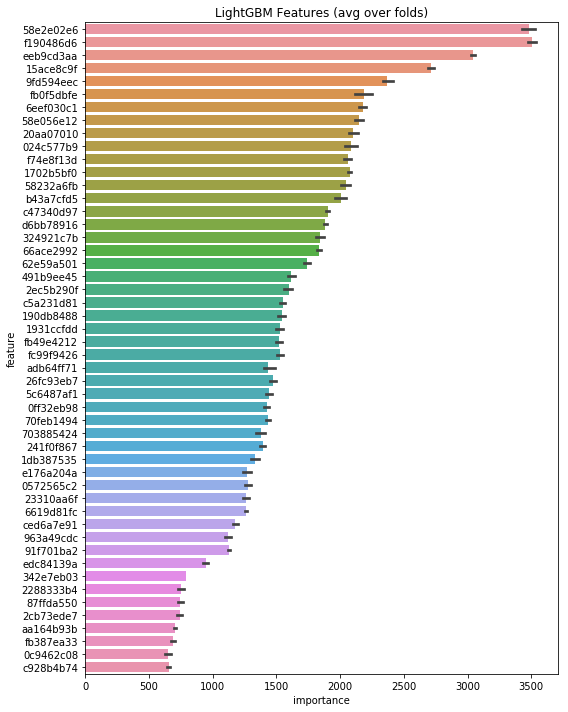

In [34]:
cols = all_feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index
best_features = all_feature_importance_df.loc[all_feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8,10))
sns.barplot(x="importance", y="feature", 
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

# To DataFrame
sub_preds = pd.DataFrame.from_dict(multi_seed_pred).replace(0,0.000001)
del multi_seed_pred; gc.collect();

In [35]:
# Take Mean over Seed prediction
mean_sub = np.expm1(sub_preds.mean(axis=1).rename(target_var))
mean_sub.index = test_index

# Submit
mean_sub.to_csv('mean_sub_ep{}_sc{}.csv'.format(optimal_rounds,round(best_cv_score,5))
            ,index = True, header=True)
mean_sub.head()

ID
000137c73    2.294374e+06
00021489f    2.248167e+06
0004d7953    2.112479e+06
00056a333    7.216750e+06
00056d8eb    2.432980e+06
Name: target, dtype: float64